## Step 1: Load Required Libraries

We start by importing necessary Python libraries for data manipulation (`pandas`, `numpy`) and CSV handling.


In [1]:
import csv
import pandas as pd
import numpy as np

## Step 2: Load Dataset

We load the funnel dataset containing user-level information including funnel stage flags (e.g., KYC submitted), timestamps for each step, and metadata like country and acquisition channel.

We also inspect the data types to ensure time columns are recognized properly later.


In [105]:
# Load data and check column types

funnel_data = pd.read_csv('funnel_data_with_timestamps.csv')
funnel_data.dtypes

user_id                 object
age                      int64
country                 object
acquisition_channel     object
account_created          int64
email_verified           int64
kyc_submitted            int64
kyc_approved             int64
first_deposit            int64
first_transaction        int64
account_created_at      object
email_verified_at       object
kyc_submitted_at        object
kyc_approved_at         object
first_deposit_at        object
first_transaction_at    object
dtype: object

## Step 3: Preview Raw Data

We view the first few rows of the dataset to verify structure, identify potential missing values, and get a general feel for the shape and content.


In [3]:
# Preview the first 10 rows to understand structure and data quality
funnel_data.head(10)

,user_id,age,country,acquisition_channel,account_created,email_verified,kyc_submitted,kyc_approved,first_deposit,first_transaction,account_created_at,email_verified_at,kyc_submitted_at,kyc_approved_at,first_deposit_at,first_transaction_at
0,user_1,56,Germany,Paid,1,0,0,0,0,0,2025-06-09 13:00:00,NaN,NaN,NaN,NaN,NaN
1,user_2,46,France,Paid,1,1,0,0,0,0,2025-06-07 02:00:00,2025-06-08 17:00:00,NaN,NaN,NaN,NaN
2,user_3,32,France,Referral,1,1,1,1,1,1,2025-06-05 20:00:00,2025-06-07 08:00:00,2025-06-07 22:00:00,2025-06-08 21:00:00,2025-06-09 17:00:00,2025-06-10 13:00:00
3,user_4,25,Germany,Referral,1,1,1,1,0,0,2025-06-01 09:00:00,2025-06-01 18:00:00,2025-06-03 15:00:00,2025-06-04 10:00:00,NaN,NaN
4,user_5,38,Nigeria,Organic,1,1,1,1,1,1,2025-06-05 03:00:00,2025-06-06 03:00:00,2025-06-06 13:00:00,2025-06-07 03:00:00,2025-06-07 05:00:00,2025-06-07 19:00:00
5,user_6,56,France,Paid,1,1,1,1,1,0,2025-06-03 11:00:00,2025-06-04 21:00:00,2025-06-07 02:00:00,2025-06-07 18:00:00,2025-06-08 04:00:00,NaN
6,user_7,36,India,Referral,1,1,0,0,0,0,2025-06-06 22:00:00,2025-06-07 01:00:00,NaN,NaN,NaN,NaN
7,user_8,40,India,Social,1,1,1,1,1,1,2025-06-02 08:00:00,2025-06-04 00:00:00,2025-06-04 16:00:00,2025-06-05 06:00:00,2025-06-07 01:00:00,2025-06-07 08:00:00
8,user_9,28,UK,Paid,1,1,1,1,1,1,2025-06-02 10:00:00,2025-06-03 14:00:00,2025-06-06 08:00:00,2025-06-07 03:00:00,2025-06-09 00:00:00,2025-06-09 07:00:00
9,user_10,28,Germany,Paid,1,1,0,0,0,0,2025-06-02 15:00:00,2025-06-02 23:00:00,NaN,NaN,NaN,NaN


## Step 4: Convert timestamp columns to datetime format

In [4]:
date_columns = ['account_created_at', 'email_verified_at','kyc_submitted_at', 'kyc_approved_at', 'first_deposit_at', 'first_transaction_at']

for col in date_columns:
    funnel_data[col] = pd.to_datetime(funnel_data[col])

print(funnel_data.dtypes)

user_id                         object
age                              int64
country                         object
acquisition_channel             object
account_created                  int64
email_verified                   int64
kyc_submitted                    int64
kyc_approved                     int64
first_deposit                    int64
first_transaction                int64
account_created_at      datetime64[ns]
email_verified_at       datetime64[ns]
kyc_submitted_at        datetime64[ns]
kyc_approved_at         datetime64[ns]
first_deposit_at        datetime64[ns]
first_transaction_at    datetime64[ns]
dtype: object


## Step 5: Create a function to calculate Conversion rate for each stage in the funnel

In [195]:
#creating a function to calculate Conversion rate for each stage in the funnel

stages = ['account_created','email_verified', 'kyc_submitted', 'kyc_approved', 'first_deposit', 'first_transaction']


def calculate_funnel_metrics(funnel_data, stages):
    """
    Calculates funnel conversion metrics between consecutive stages.

    Parameters:
        funnel_data (pd.DataFrame): Dataset with binary stage columns.
        stages (list): Ordered list of funnel stage column names.

    Returns:
        pd.DataFrame: Summary of conversion, drop-offs, and rates per funnel stage.
    """
    summary = []
    base_total = funnel_data[stages[0]].sum()

    for i in range(1, len(stages)):
        prev_stage = stages[i-1]
        current_stage = stages[i]
    
        prev_total = funnel_data[prev_stage].sum()
        current_total = funnel_data[current_stage].sum()
        dropped_users = prev_total - current_total

        running_conversion = (current_total / prev_total) * 100 if prev_total > 0 else 0
        total_conversion = (current_total / base_total) * 100 if base_total > 0 else 0

        summary.append({
            "funnel": f"{prev_stage.replace('_', ' ').title()} → {current_stage.replace('_', ' ').title()}",
            "entered_stage": prev_total,
            "converted": current_total,
            "dropped": dropped_users,
            "running_conversion_rate (%)": round(running_conversion, 2),
            "total_conversion_rate (%)": round(total_conversion, 2)
        })

    return pd.DataFrame(summary)


In [6]:
#applying the function to our data
calculate_funnel_metrics(funnel_data, stages)

,funnel,entered_stage,converted,dropped,running_conversion_rate (%),total_conversion_rate (%)
0,Account Created → Email Verified,5000,4493,507,89.86,89.86
1,Email Verified → Kyc Submitted,4493,3496,997,77.81,69.92
2,Kyc Submitted → Kyc Approved,3496,2928,568,83.75,58.56
3,Kyc Approved → First Deposit,2928,1934,994,66.05,38.68
4,First Deposit → First Transaction,1934,1444,490,74.66,28.88


/var/folders/mb/jyb_9hkn3gbf9b6p52xkfk7h0000gn/T/ipykernel_9985/3969955466.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


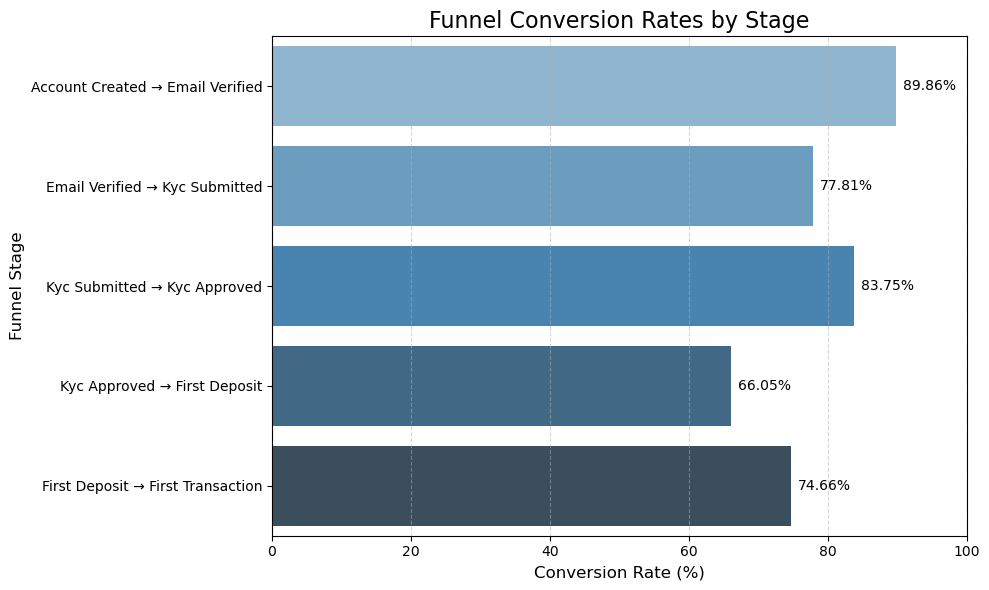

In [107]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate metrics
summary_df = calculate_funnel_metrics(funnel_data, stages)

# Plot: Funnel Step-by-Step Conversion
plt.figure(figsize=(10, 6))
barplot = sns.barplot(
    data=summary_df,
    x='running_conversion_rate (%)',
    y='funnel',
    palette='Blues_d'
)

# Add value labels to bars
for index, row in summary_df.iterrows():
    plt.text(
        x=row['running_conversion_rate (%)'] + 1,  # slight nudge right of bar
        y=index,
        s=f"{row['running_conversion_rate (%)']:.2f}%",
        va='center',
        fontsize=10,
        color='black'
    )


plt.title('Funnel Conversion Rates by Stage', fontsize=16)
plt.xlabel('Conversion Rate (%)', fontsize=12)
plt.ylabel('Funnel Stage', fontsize=12)
plt.xlim(0, 100)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()

plt.show()


### Insight
- The **KYC Approved → First Deposit** stage has the **lowest conversion rate** at ~66%, indicating a **34% drop**.
- This stage will be our focus for deeper investigation.


## Country-Level Drop-Off Analysis

In this section, we segment funnel performance by user country. Our focus is on the `KYC Approved → First Deposit` step, which previously showed the highest drop-off (~34%).

We want to know: 
- Are certain countries driving this drop more than others?
- Are there regional product friction points or payment UX issues?


/var/folders/mb/jyb_9hkn3gbf9b6p52xkfk7h0000gn/T/ipykernel_9985/2070980506.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


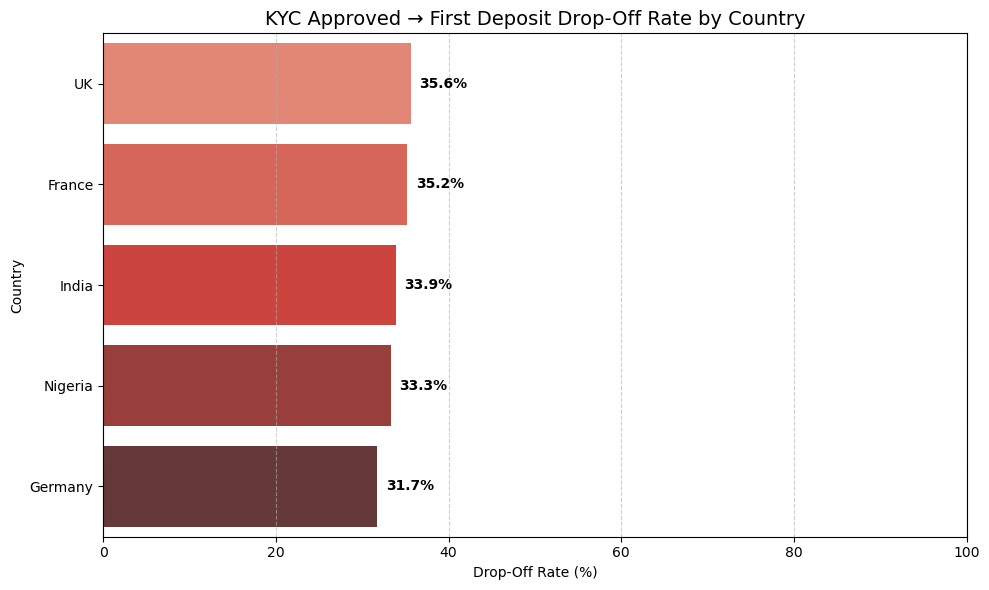

In [201]:
# Step 1: Get all countries present
countries = funnel_data['country'].dropna().unique()
country_funnels = []

# Step 2: Calculate funnel metrics for each country
for country in countries:
    df_country = funnel_data[funnel_data['country'] == country]
    summary = calculate_funnel_metrics(df_country, stages)
    summary['country'] = country
    summary['dropoff_rate (%)'] = 100 - summary['running_conversion_rate (%)']
    country_funnels.append(summary)

# Step 3: Combine all into one dataframe
country_summary = pd.concat(country_funnels)

# (Optional) Filter out countries with low sample sizes at the target step
country_summary_filtered = country_summary[
    country_summary['funnel'] == 'Kyc Approved → First Deposit'
].groupby('country').filter(lambda x: x['converted'].sum() >= 50)

# Step 4: Focus only on KYC → First Deposit step
kyc_to_deposit = country_summary_filtered[
    country_summary_filtered['funnel'] == 'Kyc Approved → First Deposit'
][['country', 'funnel', 'running_conversion_rate (%)', 'dropoff_rate (%)']]

# Step 5: Sort by conversion rate
kyc_to_deposit = kyc_to_deposit.sort_values('running_conversion_rate (%)', ascending=True)

# Step 6: Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Reset index to avoid label misalignment
kyc_to_deposit = kyc_to_deposit.reset_index(drop=True)

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=kyc_to_deposit,
    x='dropoff_rate (%)',
    y='country',
    palette='Reds_d'  # Optional: red color to signify drop-off
)

plt.title('KYC Approved → First Deposit Drop-Off Rate by Country', fontsize=14)
plt.xlabel('Drop-Off Rate (%)')
plt.ylabel('Country')
plt.xlim(0, 100)
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Add drop-off rate labels on bars
for i, row in kyc_to_deposit.iterrows():
    ax.text(
        row['dropoff_rate (%)'] + 1,
        i,
        f"{row['dropoff_rate (%)']:.1f}%",
        va='center',
        fontsize=10,
        weight='bold'
    )

plt.tight_layout()
plt.show()


### Insight: Country
- France had the **highest drop-off** at 35%.
- However, all countries fall between **31%–36%**, suggesting **no regional outliers**.
- Location is **not a significant factor** in explaining the drop-off.


## Acquisition Channel Drop-Off Analysis

This section explores how drop-off at the `KYC Approved → First Deposit` stage varies by acquisition channel (e.g., Organic, Paid, Referral).

The goal is to assess whether some channels bring in higher-intent users and whether certain campaigns may be underperforming post-KYC.


/var/folders/mb/jyb_9hkn3gbf9b6p52xkfk7h0000gn/T/ipykernel_9985/2333713726.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


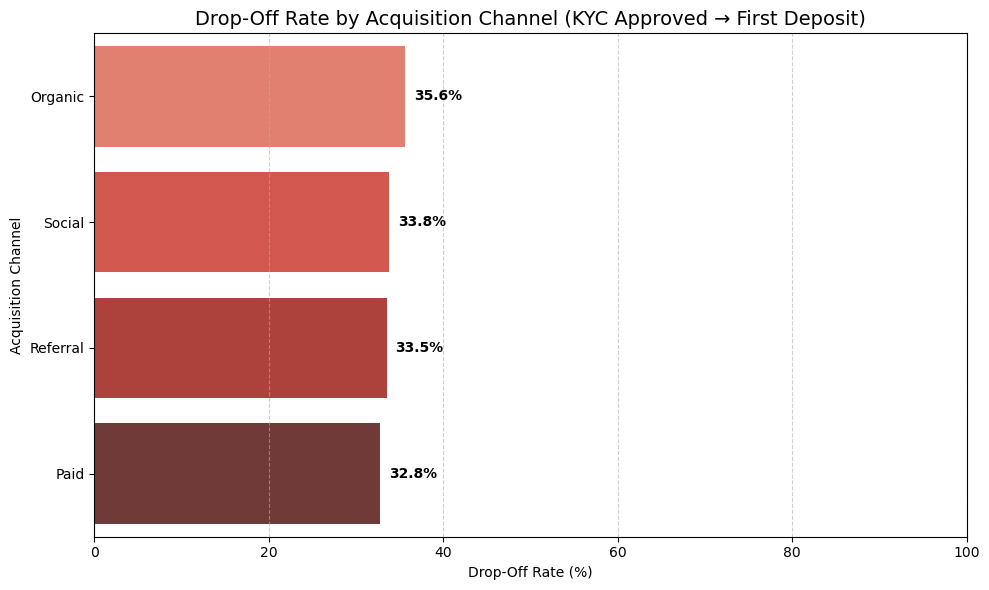

In [203]:
# Step 1: Get all acquisition channels
acquisition_channels = funnel_data['acquisition_channel'].dropna().unique()
acquisition_channel_funnels = []

# Step 2: Funnel metrics for each acquisition channel
for acquisition_channel in acquisition_channels:
    df_acquisition = funnel_data[funnel_data['acquisition_channel'] == acquisition_channel]
    summary = calculate_funnel_metrics(df_acquisition, stages)
    summary['acquisition_channel'] = acquisition_channel
    summary['dropoff_rate (%)'] = 100 - summary['running_conversion_rate (%)']
    acquisition_channel_funnels.append(summary)

# Step 3: Combine and filter
acquisition_channel_summary = pd.concat(acquisition_channel_funnels)
kyc_to_deposit = acquisition_channel_summary[
    acquisition_channel_summary['funnel'] == 'Kyc Approved → First Deposit'
][['acquisition_channel', 'funnel', 'running_conversion_rate (%)', 'dropoff_rate (%)']]

# Step 4: Sort
kyc_to_deposit = kyc_to_deposit.sort_values('dropoff_rate (%)', ascending=False).reset_index(drop=True)

# Step 5: Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(
    data=kyc_to_deposit,
    x='dropoff_rate (%)',
    y='acquisition_channel',
    palette='Reds_d'
)

plt.title('Drop-Off Rate by Acquisition Channel (KYC Approved → First Deposit)', fontsize=14)
plt.xlabel('Drop-Off Rate (%)')
plt.ylabel('Acquisition Channel')
plt.xlim(0, 100)
plt.grid(axis='x', linestyle='--', alpha=0.6)

# Step 6: Add data labels
for i, row in kyc_to_deposit.iterrows():
    ax.text(
        row['dropoff_rate (%)'] + 1,
        i,
        f"{row['dropoff_rate (%)']:.1f}%",
        va='center',
        fontsize=10,
        weight='bold'
    )

plt.tight_layout()
plt.show()


### Insights: Acquisition Channel Drop-Off

Surprisingly, **Organic users**, who are typically expected to have higher intent, showed the **highest drop-off rate** at the `KYC Approved → First Deposit` stage.

This disproves the initial hypothesis that users acquired via **paid channels** might be lower-quality or less motivated. In reality, **conversion performance across channels** was relatively uniform, and **Organic lagged slightly**.

---

### Next Step: Investigating KYC Approval Delay

Since acquisition channel doesn’t explain the drop-off, we now turn to explore whether **KYC approval delay** impacts a user's likelihood to proceed with a deposit. Hypothesis:

> **The longer it takes to approve a user's KYC, the more likely they are to drop off.**


In [207]:
# Step 1: Calculate delay in hours
funnel_data['kyc_approval_delay_hours'] = (
    pd.to_datetime(funnel_data['kyc_approved_at']) - pd.to_datetime(funnel_data['kyc_submitted_at'])
).dt.total_seconds() / 3600

# Step 2: Bucket delays
bins = [0, 1, 6, 24, 72, 168, float('inf')]
labels = ['<1hr', '1–6hr', '6–24hr', '1–3 days', '3–7 days', '>7 days']
funnel_data['kyc_delay_bucket'] = pd.cut(
    funnel_data['kyc_approval_delay_hours'],
    bins=bins,
    labels=labels,
    right=False
)

# Step 3: Aggregate metrics
delay_conversion = funnel_data.groupby('kyc_delay_bucket', observed=True).agg(
    total_users=('kyc_approved_at', 'count'),
    converted=('first_deposit', 'sum')
).reset_index()

# Step 4: Calculate rates
delay_conversion['conversion_rate (%)'] = (
    delay_conversion['converted'] / delay_conversion['total_users']
) * 100

delay_conversion['dropoff_rate (%)'] = 100 - delay_conversion['conversion_rate (%)']

# Step 5 : Ensure correct order of labels
delay_conversion['kyc_delay_bucket'] = delay_conversion['kyc_delay_bucket'].astype(str)


/var/folders/mb/jyb_9hkn3gbf9b6p52xkfk7h0000gn/T/ipykernel_9985/2689121450.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


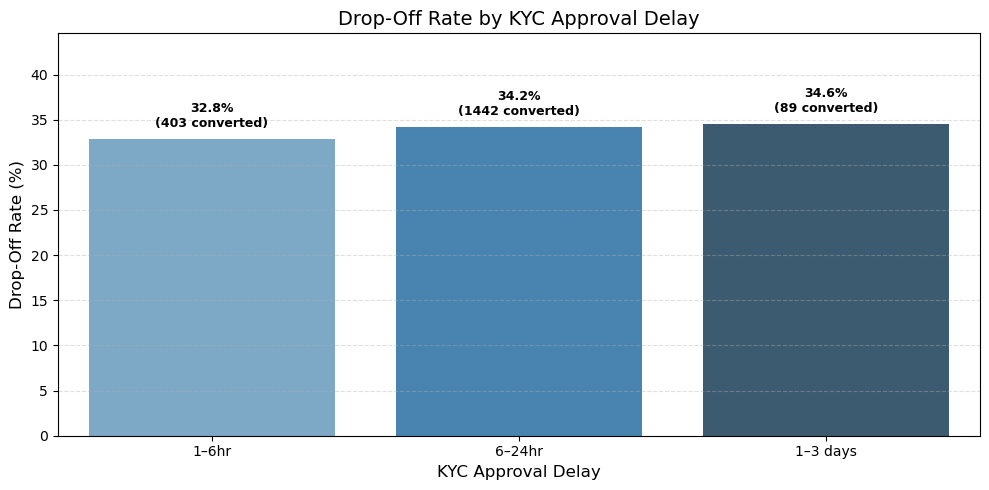

In [209]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot setup
plt.figure(figsize=(10, 5))
sns.barplot(
    x='kyc_delay_bucket',
    y='dropoff_rate (%)',
    data=delay_conversion,
    palette='Blues_d'
)

# Titles and axis labels
plt.title('Drop-Off Rate by KYC Approval Delay', fontsize=14)
plt.xlabel('KYC Approval Delay', fontsize=12)
plt.ylabel('Drop-Off Rate (%)', fontsize=12)
plt.ylim(0, delay_conversion['dropoff_rate (%)'].max() + 10)
plt.grid(axis='y', linestyle='--', alpha=0.4)

# Add value labels
for i, row in delay_conversion.iterrows():
    plt.text(
        i,
        row['dropoff_rate (%)'] + 1,
        f"{row['dropoff_rate (%)']:.1f}%\n({int(row['converted'])} converted)",
        ha='center',
        va='bottom',
        fontsize=9,
        weight='bold'
    )

plt.tight_layout()
plt.show()


### 🔍 Insight: KYC Approval Delay

There were no significant outliers across KYC approval delay buckets.  
This suggests that the **time it takes to approve KYC does not meaningfully impact whether users go on to make a deposit**.

In other words, a slower KYC process does not appear to be the primary driver of drop-off at this stage.

---

We’ll now explore whether **how quickly users submit their KYC after signing up** has a stronger influence on conversion.


/var/folders/mb/jyb_9hkn3gbf9b6p52xkfk7h0000gn/T/ipykernel_9985/2887029047.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  signup_kyc_summary = funnel_data.groupby('signup_to_kyc_bucket').agg(
/var/folders/mb/jyb_9hkn3gbf9b6p52xkfk7h0000gn/T/ipykernel_9985/2887029047.py:32: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


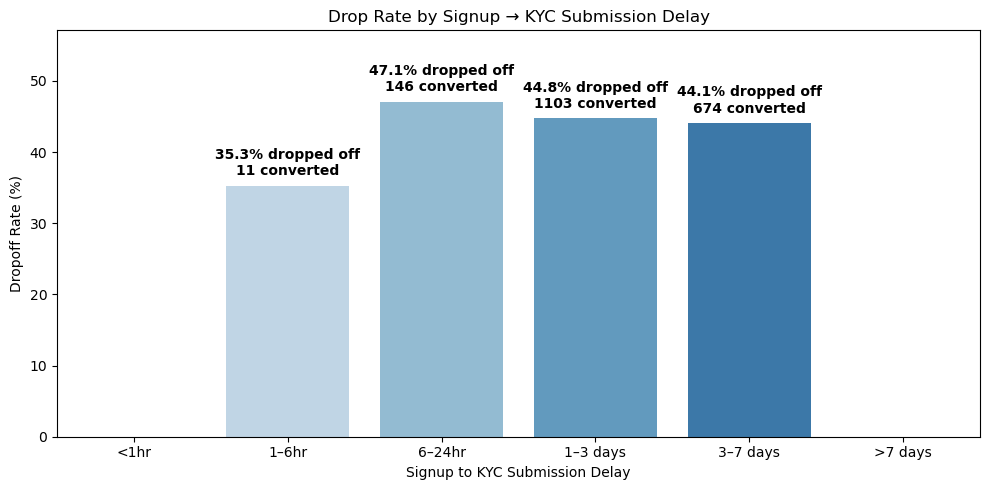

In [212]:
# Step 1: Convert time columns to datetime
funnel_data['account_created_at'] = pd.to_datetime(funnel_data['account_created_at'])
funnel_data['kyc_submitted_at'] = pd.to_datetime(funnel_data['kyc_submitted_at'])

# Step 2: Calculate time delay from signup to KYC submission (in hours)
funnel_data['signup_to_kyc_delay'] = (
    funnel_data['kyc_submitted_at'] - funnel_data['account_created_at']
).dt.total_seconds() / 3600

# Step 3: Bucket the delay into intervals
bins = [0, 1, 6, 24, 72, 168, float('inf')]
labels = ['<1hr', '1–6hr', '6–24hr', '1–3 days', '3–7 days', '>7 days']
funnel_data['signup_to_kyc_bucket'] = pd.cut(funnel_data['signup_to_kyc_delay'], bins=bins, labels=labels)

# Step 4: Aggregate converted & total users per delay bucket
signup_kyc_summary = funnel_data.groupby('signup_to_kyc_bucket').agg(
    converted=('first_deposit', 'sum'),
    total_users=('first_deposit', 'count')
).reset_index()

# Step 5: Calculate conversion and dropoff rates
signup_kyc_summary['Conversion Rate (%)'] = (
    signup_kyc_summary['converted'] / signup_kyc_summary['total_users']
) * 100
signup_kyc_summary['Dropoff Rate (%)'] = 100 - signup_kyc_summary['Conversion Rate (%)']

# Step 6: Plot Dropoff Rate
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.barplot(
    x='signup_to_kyc_bucket',
    y='Dropoff Rate (%)',
    data=signup_kyc_summary,
    palette='Blues'
)

plt.title('Drop Rate by Signup → KYC Submission Delay')
plt.xlabel('Signup to KYC Submission Delay')
plt.ylabel('Dropoff Rate (%)')

# Add top padding to y-axis
max_dropoff = signup_kyc_summary['Dropoff Rate (%)'].max()
plt.ylim(0, max_dropoff + 10)

# Add labels on bars
for i, row in signup_kyc_summary.iterrows():
    plt.text(
        i,
        row['Dropoff Rate (%)'] + 1,
        f"{row['Dropoff Rate (%)']:.1f}% dropped off\n{int(row['converted'])} converted",
        ha='center',
        va='bottom',
        fontsize=10,
        weight='bold'
    )

plt.tight_layout()
plt.show()


/var/folders/mb/jyb_9hkn3gbf9b6p52xkfk7h0000gn/T/ipykernel_9985/822485964.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='signup_to_kyc_bucket', y='Dropoff Rate (%)', data=signup_kyc_summary, palette='Blues')
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


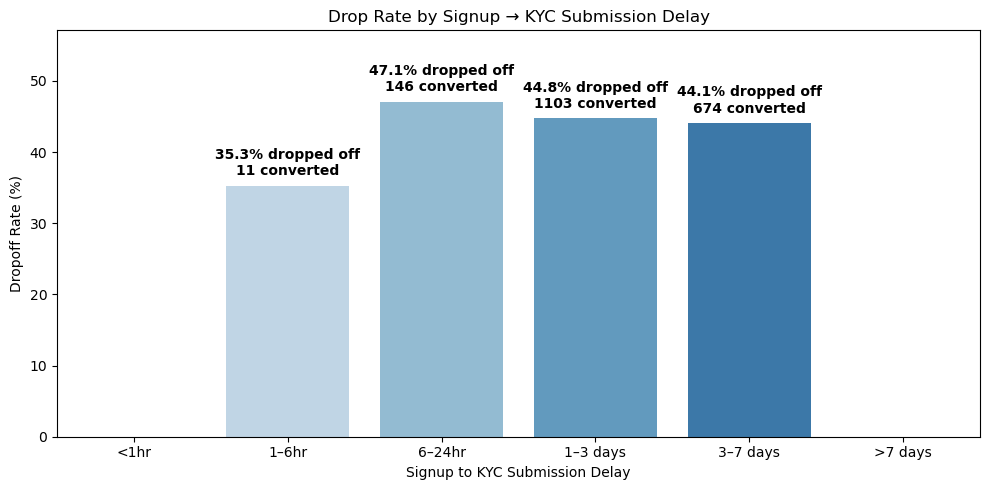

In [214]:
# Step 3: Plot
plt.figure(figsize=(10, 5))
sns.barplot(x='signup_to_kyc_bucket', y='Dropoff Rate (%)', data=signup_kyc_summary, palette='Blues')
plt.title('Drop Rate by Signup → KYC Submission Delay')
plt.xlabel('Signup to KYC Submission Delay')
plt.ylabel('Dropoff Rate (%)')

# Add top padding to y-axis
max_dropoff = signup_kyc_summary['Dropoff Rate (%)'].max()
plt.ylim(0, max_dropoff + 10)  # 10% buffer above highest bar

# Step 4: Add value labels
for i, row in signup_kyc_summary.iterrows():
    plt.text(
        i,
        row['Dropoff Rate (%)'] + 1,
        f"{row['Dropoff Rate (%)']:.1f}% dropped off\n{int(row['converted'])} converted",
        ha='center',
        va='bottom',
        fontsize=10,
        weight='bold'
    )

plt.tight_layout()
plt.show()


### 🔍 Insight: Drop-Off by Signup → KYC Submission Delay

The drop-off rate does not drastically vary across signup-to-KYC submission delay buckets. Here's what stands out:

- Users who submitted KYC **within 1–6 hours** had the **lowest drop-off rate (35.3%)**, but the total number of converted users was **very low (11)** – likely too small to draw a solid conclusion.
- Majority of users submitted KYC between **6–24 hours** or **1–3 days**, and their drop-off rates were **around 44–47%**, fairly consistent.
- Even users who took **3–7 days** showed similar drop-off behavior (~44%).

🧠 **Conclusion**: The time delay between signing up and submitting KYC **does not appear to be a strong driver of drop-off**. Most users, regardless of how quickly they submit KYC, exhibit similar conversion behavior.

This again points to **post-KYC experience** (e.g., product clarity, deposit incentives, UI cues) as the more likely cause of user attrition.


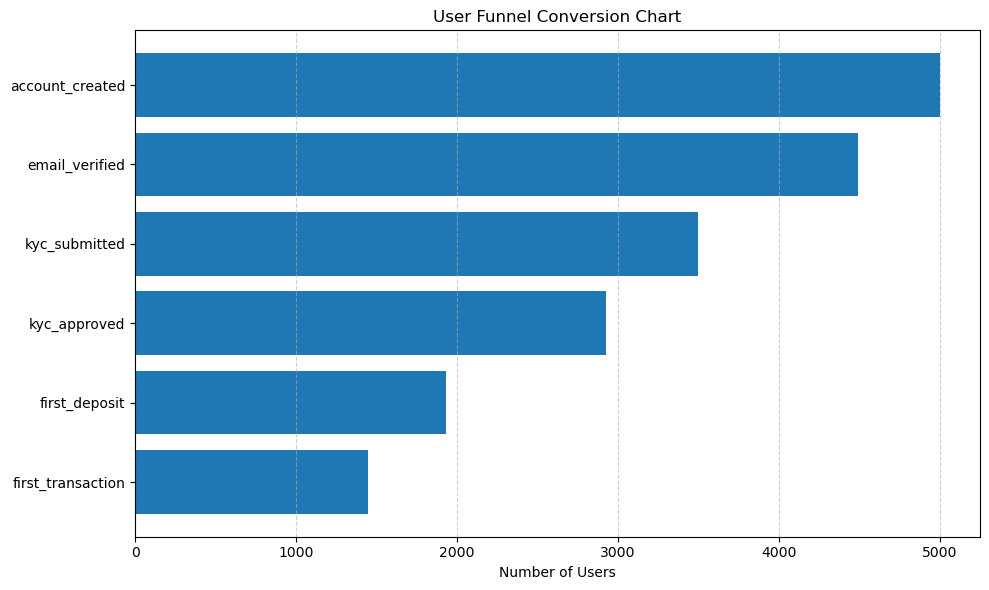

In [227]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your dataset (replace with your actual file if needed)
df = pd.read_csv("funnel_data_with_timestamps.csv")

# Define the funnel stages in order
funnel_stages = [
    "account_created",
    "email_verified",
    "kyc_submitted",
    "kyc_approved",
    "first_deposit",
    "first_transaction"
]

# Calculate the number of users who completed each stage
funnel_counts = [df[stage].sum() for stage in funnel_stages]

# Plot as horizontal bar chart to represent the funnel
plt.figure(figsize=(10, 6))
plt.barh(funnel_stages[::-1], funnel_counts[::-1])  # Reverse to show top-down
plt.xlabel("Number of Users")
plt.title("User Funnel Conversion Chart")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


### 🧠 Funnel Insights

- ✅ **Strong Retention:** 90% of users verify their email.
- 🚧 **KYC Drop-Off:** 22% of users never submit KYC after email verification.
- 🧊 **Friction at First Deposit:** 33% drop after KYC approval — likely UX or trust issues.
- 💸 **Final Activation Weakness:** 25% of depositors never transact — we may need nudges, onboarding, or activation campaigns.

These numbers suggest 2 urgent tests:
1. **Post-KYC Nudge Experiment** – show a time-sensitive prompt to deposit.
2. **Transaction Incentives** – reward first action after deposit to improve activation.


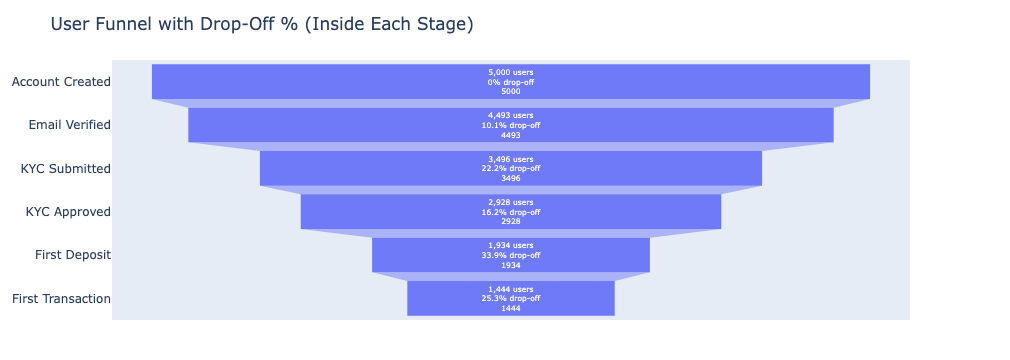

In [233]:
import pandas as pd
import plotly.graph_objects as go

# Load your dataset
df = pd.read_csv("funnel_data_with_timestamps.csv")

# Define the funnel steps
funnel_stages = [
    "Account Created",
    "Email Verified",
    "KYC Submitted",
    "KYC Approved",
    "First Deposit",
    "First Transaction"
]

funnel_columns = [
    "account_created",
    "email_verified",
    "kyc_submitted",
    "kyc_approved",
    "first_deposit",
    "first_transaction"
]

# Get counts at each stage
counts = [df[col].sum() for col in funnel_columns]

# Compute drop-off % from previous step
dropoff = [0]  # No drop-off for the first stage
for i in range(1, len(counts)):
    dropped = counts[i-1] - counts[i]
    percent = (dropped / counts[i-1]) * 100 if counts[i-1] != 0 else 0
    dropoff.append(round(percent, 1))

# Format the text inside the funnel segments
internal_text = [f"{count:,} users<br>{drop}% drop-off"
                 for count, drop in zip(counts, dropoff)]

# Plot funnel
fig = go.Figure(go.Funnel(
    y=funnel_stages,
    x=counts,
    text=internal_text,
    textposition="inside",
    textfont=dict(size=14, color='white'),
    opacity=0.9
))

fig.update_layout(
    title="User Funnel with Drop-Off % (Inside Each Stage)",
    margin=dict(l=100, r=100, t=60, b=40)
)

fig.show()
